In [1]:
import os

import pandas as pd
import dask.dataframe as dd
import xarray as xr
import numpy as np

from dask import delayed
from dask.distributed import Client

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

from shapely.geometry import Point

In [2]:
client = Client()

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59139,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:59155,Total threads: 4
Dashboard: http://127.0.0.1:59157/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:59145,


In [4]:
data_dir = '/Volumes/Shores/AERONET/AOD/AOD20/ALL_POINTS'
files = os.listdir(data_dir)

In [5]:
def read_csv(filename, **kwargs):
    return pd.read_csv(filename, skiprows=5, header=1, encoding_errors='replace', **kwargs)

In [6]:
dfs = [read_csv(f'{data_dir}/{f}', nrows=1) for f in files]
df = pd.concat(dfs)

#  Finding Locations in the US with data in 2017

In [7]:
locations = df[['AERONET_Site_Name', 'Site_Latitude(Degrees)', 'Site_Longitude(Degrees)', 'Site_Elevation(m)']]

In [8]:
names = locations['AERONET_Site_Name'].values
lats = locations['Site_Latitude(Degrees)'].values
lons = locations['Site_Longitude(Degrees)'].values

In [9]:
shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
states = shpreader.Reader(states_shp)

In [10]:
points = [(Point(lon, lat), name) for (lon, lat, name) in zip(lons, lats, names)]
points_in_state = {record.attributes['name'] : [] for record in states.records()}

for record in states.records():
    if record.attributes['name'] == 'Hawaii' or record.attributes['name'] == 'Alaska':
        continue
    for pairing in points:
        (point, name) = pairing
        if record.geometry.contains(point):
            points_in_state[record.attributes['name']].append(pairing)

In [11]:
names = [name for state, points in points_in_state.items() for point, name in points]
us_files = [f for f in files if f[18:-6] in names]

In [16]:
pd.DataFrame({'Files': [f'{data_dir}/{f}' for f in us_files]}).to_csv('data/US_aeronet_files.csv', index=False)

In [32]:
useful_files = []

for file in us_files:
    df = read_csv(f'{data_dir}/{file}')
    df['Datetime'] = pd.to_datetime(df['Date(dd:mm:yyyy)'] + ' ' + df['Time(hh:mm:ss)'], format='%d:%m:%Y %H:%M:%S')
    if np.any((df['Datetime'] > '2020-12-31') & (df['Datetime'] < '2022')):
        useful_files.append(f'{data_dir}/{file}')

In [33]:
dfs = [read_csv(f, nrows=1, 
                usecols=['AERONET_Site_Name','Site_Latitude(Degrees)', 'Site_Longitude(Degrees)',]
               ) 
       for f in useful_files]
us_locations = pd.concat(dfs)

In [34]:
us_locations.columns = ['Site Name', 'Latitude', 'Longitude']
us_locations

,Site Name,Latitude,Longitude
0,South_Greenbay,44.596330,-87.951200
0,NEON_UNDE,46.233881,-89.537250
0,Fresno_2,36.785370,-119.773020
0,Sevilleta,34.354721,-106.885002
0,ECCOE-CoconinoNF-AZ,35.447761,-111.566153
...,...,...,...
0,BONDVILLE,40.053333,-88.371944
0,NEON_YELL,44.953480,-110.539140
0,NEON-Disney,28.125039,-81.436200
0,Yuma,32.644138,-114.582780


In [35]:
us_locations.to_csv('data/locations.csv', index=False)

In [36]:
pd.DataFrame({'Files': useful_files}).to_csv('data/usefule_aeronet_files.csv', index=False)

# Map It

In [32]:
shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
states = shpreader.Reader(states_shp)

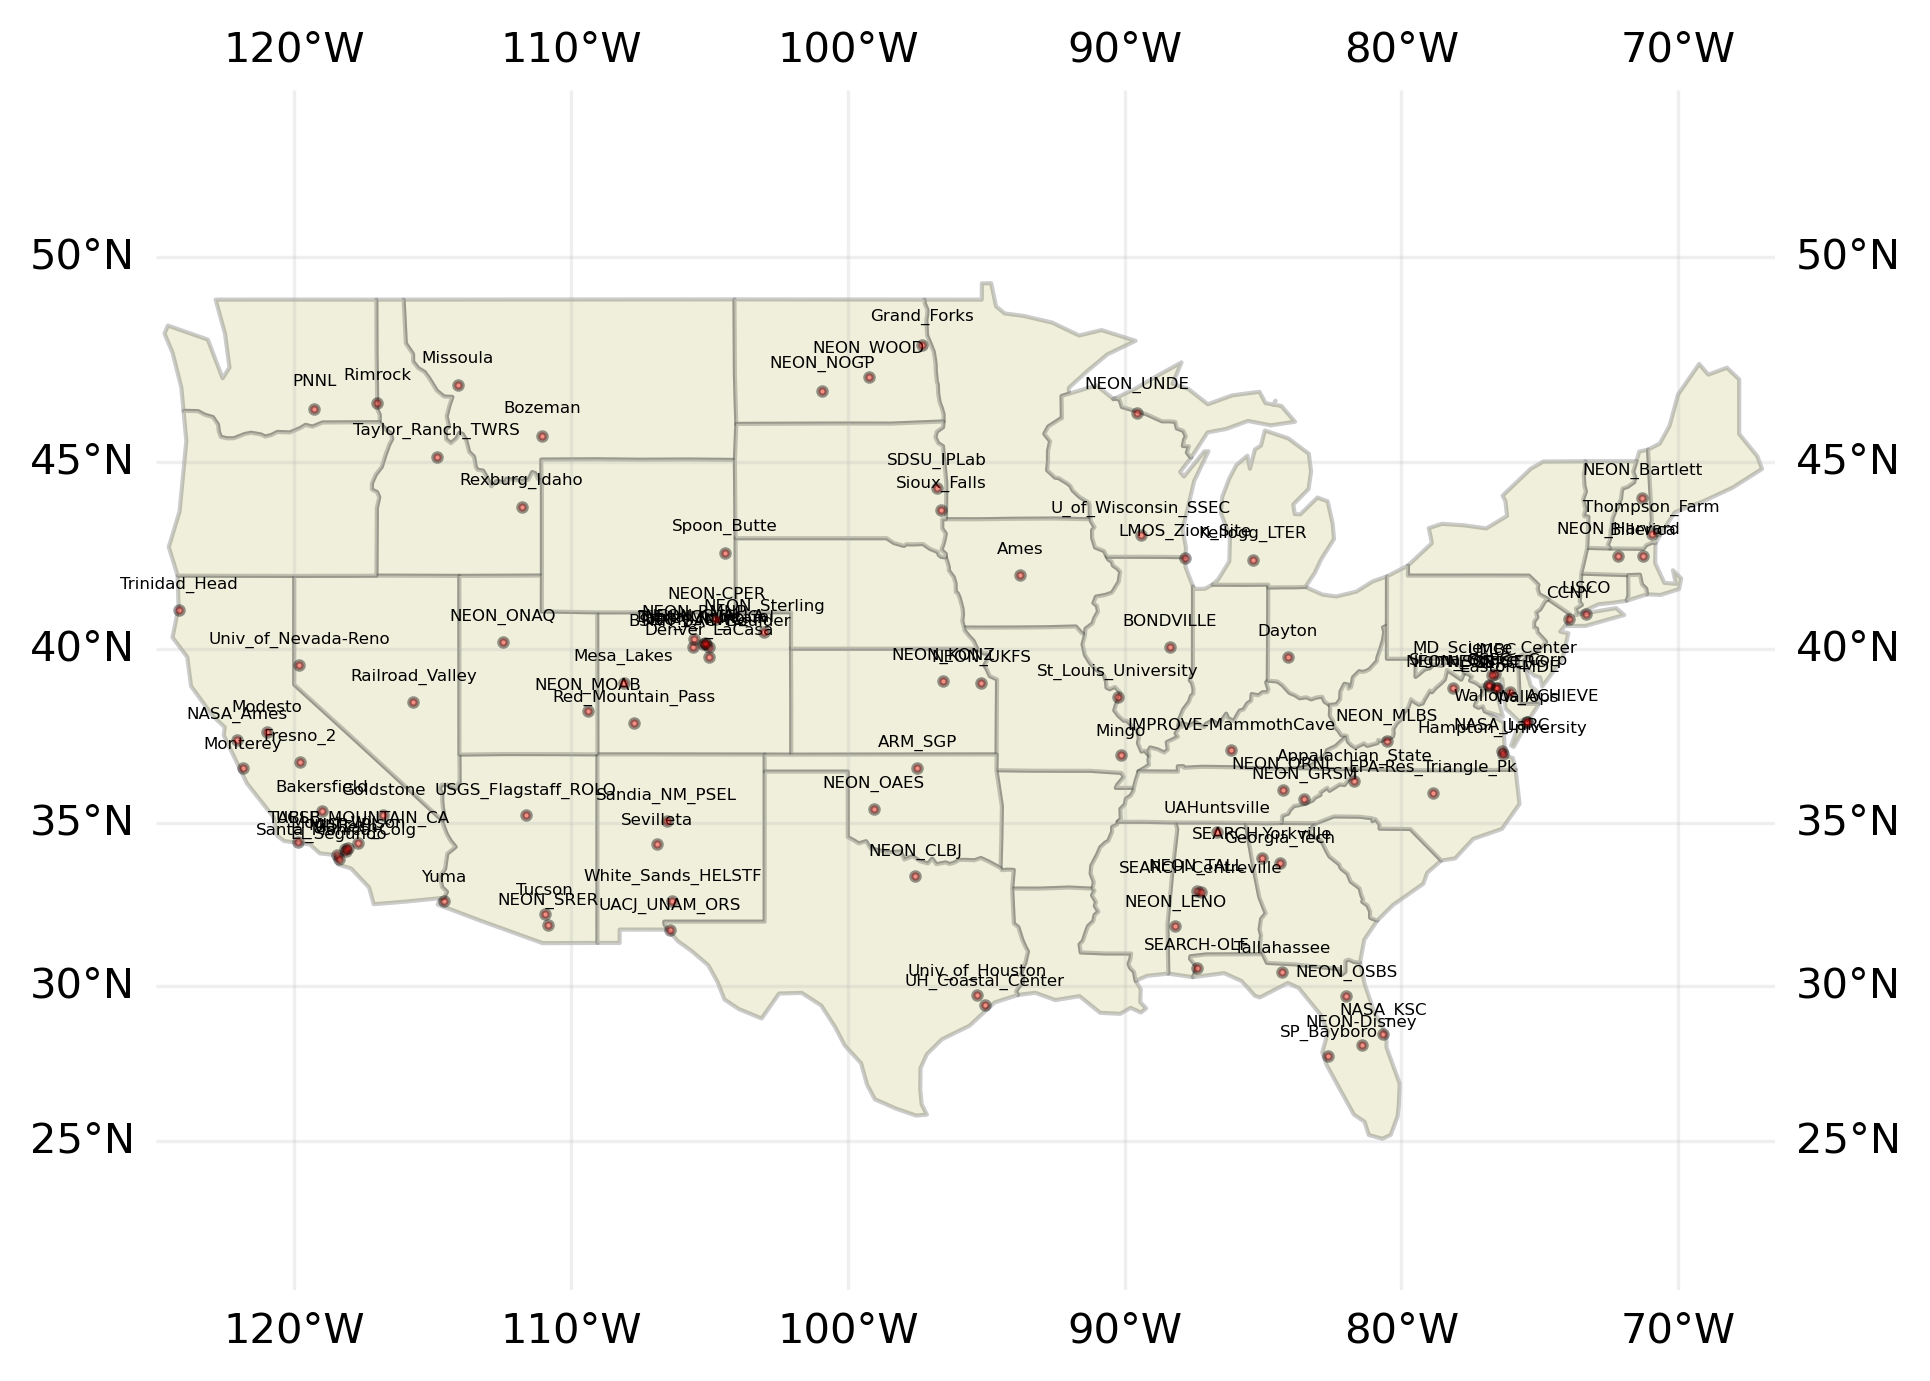

In [33]:
fig = plt.figure(dpi=300)
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.Mercator(), frameon=False)

ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.859375)
    return {'facecolor': facecolor, 'edgecolor': '#00000033'}

ax.add_geometries(
    states.geometries(),
    ccrs.PlateCarree(),
    styler=colorize_state)

ax.scatter(us_locations['Longitude'], us_locations['Latitude'],
           s=4, 
           alpha=0.4, 
           c='r',
           edgecolor='black',
           transform=ccrs.PlateCarree(), 
           zorder=10);

for i in us_locations.iterrows():
    lon, lat, name = i[1].Longitude, i[1].Latitude, i[1]['Site Name']
    ax.text(lon,
            lat + 0.5,
            name,
            ha='center',
            va='bottom',
            transform=ccrs.PlateCarree(),
            fontsize=4)

ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, alpha=0.2)
    
plt.show()

# Make One File of All US Locations

In [35]:
dfs = [delayed(read_csv)(f) for f in useful_files]
ddf = dd.from_delayed(dfs)

In [36]:
ddf = ddf.rename(columns={'Site_Longitude(Degrees)': 'Longitude', 'Site_Latitude(Degrees)': 'Latitude'})
ddf['Datetime'] = dd.to_datetime(ddf['Date(dd:mm:yyyy)'] + ' ' + ddf['Time(hh:mm:ss)'], format='%d:%m:%Y %H:%M:%S')
ddf = ddf.drop(['Date(dd:mm:yyyy)', 'Time(hh:mm:ss)'], axis=1)

In [37]:
df = ddf.compute()

In [38]:
df.to_csv('data/selected_aeronet_locations.csv', index=False)

In [39]:
df

,Day_of_Year,Day_of_Year(Fraction),AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,AOD_620nm,...,Exact_Wavelengths_of_AOD(um)_340nm,Exact_Wavelengths_of_PW(um)_935nm,Exact_Wavelengths_of_AOD(um)_681nm,Exact_Wavelengths_of_AOD(um)_709nm,Exact_Wavelengths_of_AOD(um)_Empty,Exact_Wavelengths_of_AOD(um)_Empty.1,Exact_Wavelengths_of_AOD(um)_Empty.2,Exact_Wavelengths_of_AOD(um)_Empty.3,Exact_Wavelengths_of_AOD(um)_Empty.4,Datetime
0,362,362.618287,0.007433,0.024176,0.031865,-999.0,-999.0,0.051196,-999.0,-999.0,...,0.3411,0.9365,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2014-12-28 14:50:20
1,362,362.621921,0.009779,0.029307,0.038669,-999.0,-999.0,0.060930,-999.0,-999.0,...,0.3411,0.9365,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2014-12-28 14:55:34
2,362,362.843866,0.007261,0.013883,0.016706,-999.0,-999.0,0.025144,-999.0,-999.0,...,0.3411,0.9365,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2014-12-28 20:15:10
3,364,364.618333,0.005437,0.014305,0.017724,-999.0,-999.0,0.029430,-999.0,-999.0,...,0.3411,0.9365,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2014-12-30 14:50:24
4,364,364.622106,0.009015,0.017303,0.022373,-999.0,-999.0,0.035771,-999.0,-999.0,...,0.3411,0.9365,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2014-12-30 14:55:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25143,229,229.491632,0.019508,0.059228,0.079165,-999.0,-999.0,0.120280,-999.0,-999.0,...,0.3404,0.9369,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2021-08-17 11:47:57
25144,229,229.498553,0.019763,0.059044,0.078029,-999.0,-999.0,0.118573,-999.0,-999.0,...,0.3404,0.9369,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2021-08-17 11:57:55
25145,229,229.505069,0.023451,0.061203,0.079391,-999.0,-999.0,0.118216,-999.0,-999.0,...,0.3404,0.9369,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2021-08-17 12:07:18
25146,229,229.507245,0.024262,0.061139,0.079641,-999.0,-999.0,0.118192,-999.0,-999.0,...,0.3404,0.9369,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2021-08-17 12:10:26


In [6]:
df = dd.read_csv('data/selected_aeronet_locations.csv')
df

,Day_of_Year,Day_of_Year(Fraction),AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,AOD_620nm,AOD_560nm,AOD_555nm,AOD_551nm,AOD_532nm,AOD_531nm,AOD_510nm,AOD_500nm,AOD_490nm,AOD_443nm,AOD_440nm,AOD_412nm,AOD_400nm,AOD_380nm,AOD_340nm,Precipitable_Water(cm),AOD_681nm,AOD_709nm,AOD_Empty,AOD_Empty.1,AOD_Empty.2,AOD_Empty.3,AOD_Empty.4,Triplet_Variability_1640,Triplet_Variability_1020,Triplet_Variability_870,Triplet_Variability_865,Triplet_Variability_779,Triplet_Variability_675,Triplet_Variability_667,Triplet_Variability_620,Triplet_Variability_560,Triplet_Variability_555,Triplet_Variability_551,Triplet_Variability_532,Triplet_Variability_531,Triplet_Variability_510,Triplet_Variability_500,Triplet_Variability_490,Triplet_Variability_443,Triplet_Variability_440,Triplet_Variability_412,Triplet_Variability_400,Triplet_Variability_380,Triplet_Variability_340,Triplet_Variability_Precipitable_Water(cm),Triplet_Variability_681,Triplet_Variability_709,Triplet_Variability_AOD_Empty,Triplet_Variability_AOD_Empty.1,Triplet_Variability_AOD_Empty.2,Triplet_Variability_AOD_Empty.3,Triplet_Variability_AOD_Empty.4,440-870_Angstrom_Exponent,380-500_Angstrom_Exponent,440-675_Angstrom_Exponent,500-870_Angstrom_Exponent,340-440_Angstrom_Exponent,440-675_Angstrom_Exponent[Polar],Data_Quality_Level,AERONET_Instrument_Number,AERONET_Site_Name,Latitude,Longitude,Site_Elevation(m),Solar_Zenith_Angle(Degrees),Optical_Air_Mass,Sensor_Temperature(Degrees_C),Ozone(Dobson),NO2(Dobson),Last_Date_Processed,Number_of_Wavelengths,Exact_Wavelengths_of_AOD(um)_1640nm,Exact_Wavelengths_of_AOD(um)_1020nm,Exact_Wavelengths_of_AOD(um)_870nm,Exact_Wavelengths_of_AOD(um)_865nm,Exact_Wavelengths_of_AOD(um)_779nm,Exact_Wavelengths_of_AOD(um)_675nm,Exact_Wavelengths_of_AOD(um)_667nm,Exact_Wavelengths_of_AOD(um)_620nm,Exact_Wavelengths_of_AOD(um)_560nm,Exact_Wavelengths_of_AOD(um)_555nm,Exact_Wavelengths_of_AOD(um)_551nm,Exact_Wavelengths_of_AOD(um)_532nm,Exact_Wavelengths_of_AOD(um)_531nm,Exact_Wavelengths_of_AOD(um)_510nm,Exact_Wavelengths_of_AOD(um)_500nm,Exact_Wavelengths_of_AOD(um)_490nm,Exact_Wavelengths_of_AOD(um)_443nm,Exact_Wavelengths_of_AOD(um)_440nm,Exact_Wavelengths_of_AOD(um)_412nm,Exact_Wavelengths_of_AOD(um)_400nm,Exact_Wavelengths_of_AOD(um)_380nm,Exact_Wavelengths_of_AOD(um)_340nm,Exact_Wavelengths_of_PW(um)_935nm,Exact_Wavelengths_of_AOD(um)_681nm,Exact_Wavelengths_of_AOD(um)_709nm,Exact_Wavelengths_of_AOD(um)_Empty,Exact_Wavelengths_of_AOD(um)_Empty.1,Exact_Wavelengths_of_AOD(um)_Empty.2,Exact_Wavelengths_of_AOD(um)_Empty.3,Exact_Wavelengths_of_AOD(um)_Empty.4,Datetime
npartitions=85,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [6]:
df.columns.values

array(['Day_of_Year', 'Day_of_Year(Fraction)', 'AOD_1640nm', 'AOD_1020nm',
       'AOD_870nm', 'AOD_865nm', 'AOD_779nm', 'AOD_675nm', 'AOD_667nm',
       'AOD_620nm', 'AOD_560nm', 'AOD_555nm', 'AOD_551nm', 'AOD_532nm',
       'AOD_531nm', 'AOD_510nm', 'AOD_500nm', 'AOD_490nm', 'AOD_443nm',
       'AOD_440nm', 'AOD_412nm', 'AOD_400nm', 'AOD_380nm', 'AOD_340nm',
       'Precipitable_Water(cm)', 'AOD_681nm', 'AOD_709nm', 'AOD_Empty',
       'AOD_Empty.1', 'AOD_Empty.2', 'AOD_Empty.3', 'AOD_Empty.4',
       'Triplet_Variability_1640', 'Triplet_Variability_1020',
       'Triplet_Variability_870', 'Triplet_Variability_865',
       'Triplet_Variability_779', 'Triplet_Variability_675',
       'Triplet_Variability_667', 'Triplet_Variability_620',
       'Triplet_Variability_560', 'Triplet_Variability_555',
       'Triplet_Variability_551', 'Triplet_Variability_532',
       'Triplet_Variability_531', 'Triplet_Variability_510',
       'Triplet_Variability_500', 'Triplet_Variability_490',
       '

In [7]:
df['AOD_550nm'] = df['AOD_675nm'] * (550 / 675) ** -df['440-675_Angstrom_Exponent']

In [11]:
computed = df.compute()

In [12]:
computed.to_csv('data/aeronet_550nm_extrapolated.csv', index=False)